# Memorization vs Generalization

Neuronale Netze werden immer größer. 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization".
- _Generalisierung_: Aus den Trainingsdaten werden Features extrahiert, mit deren Hilfe unbekannte Daten entsprechend klassifiziert werden.

[Beleg?]

In heutigen Machine Learning-Anwendungsgebieten meint der Begriff _lernen_ zweiteres. In diesem Notebook wird der Begriff entsprechend verwendet. 



In [5]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Using TensorFlow backend.


Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

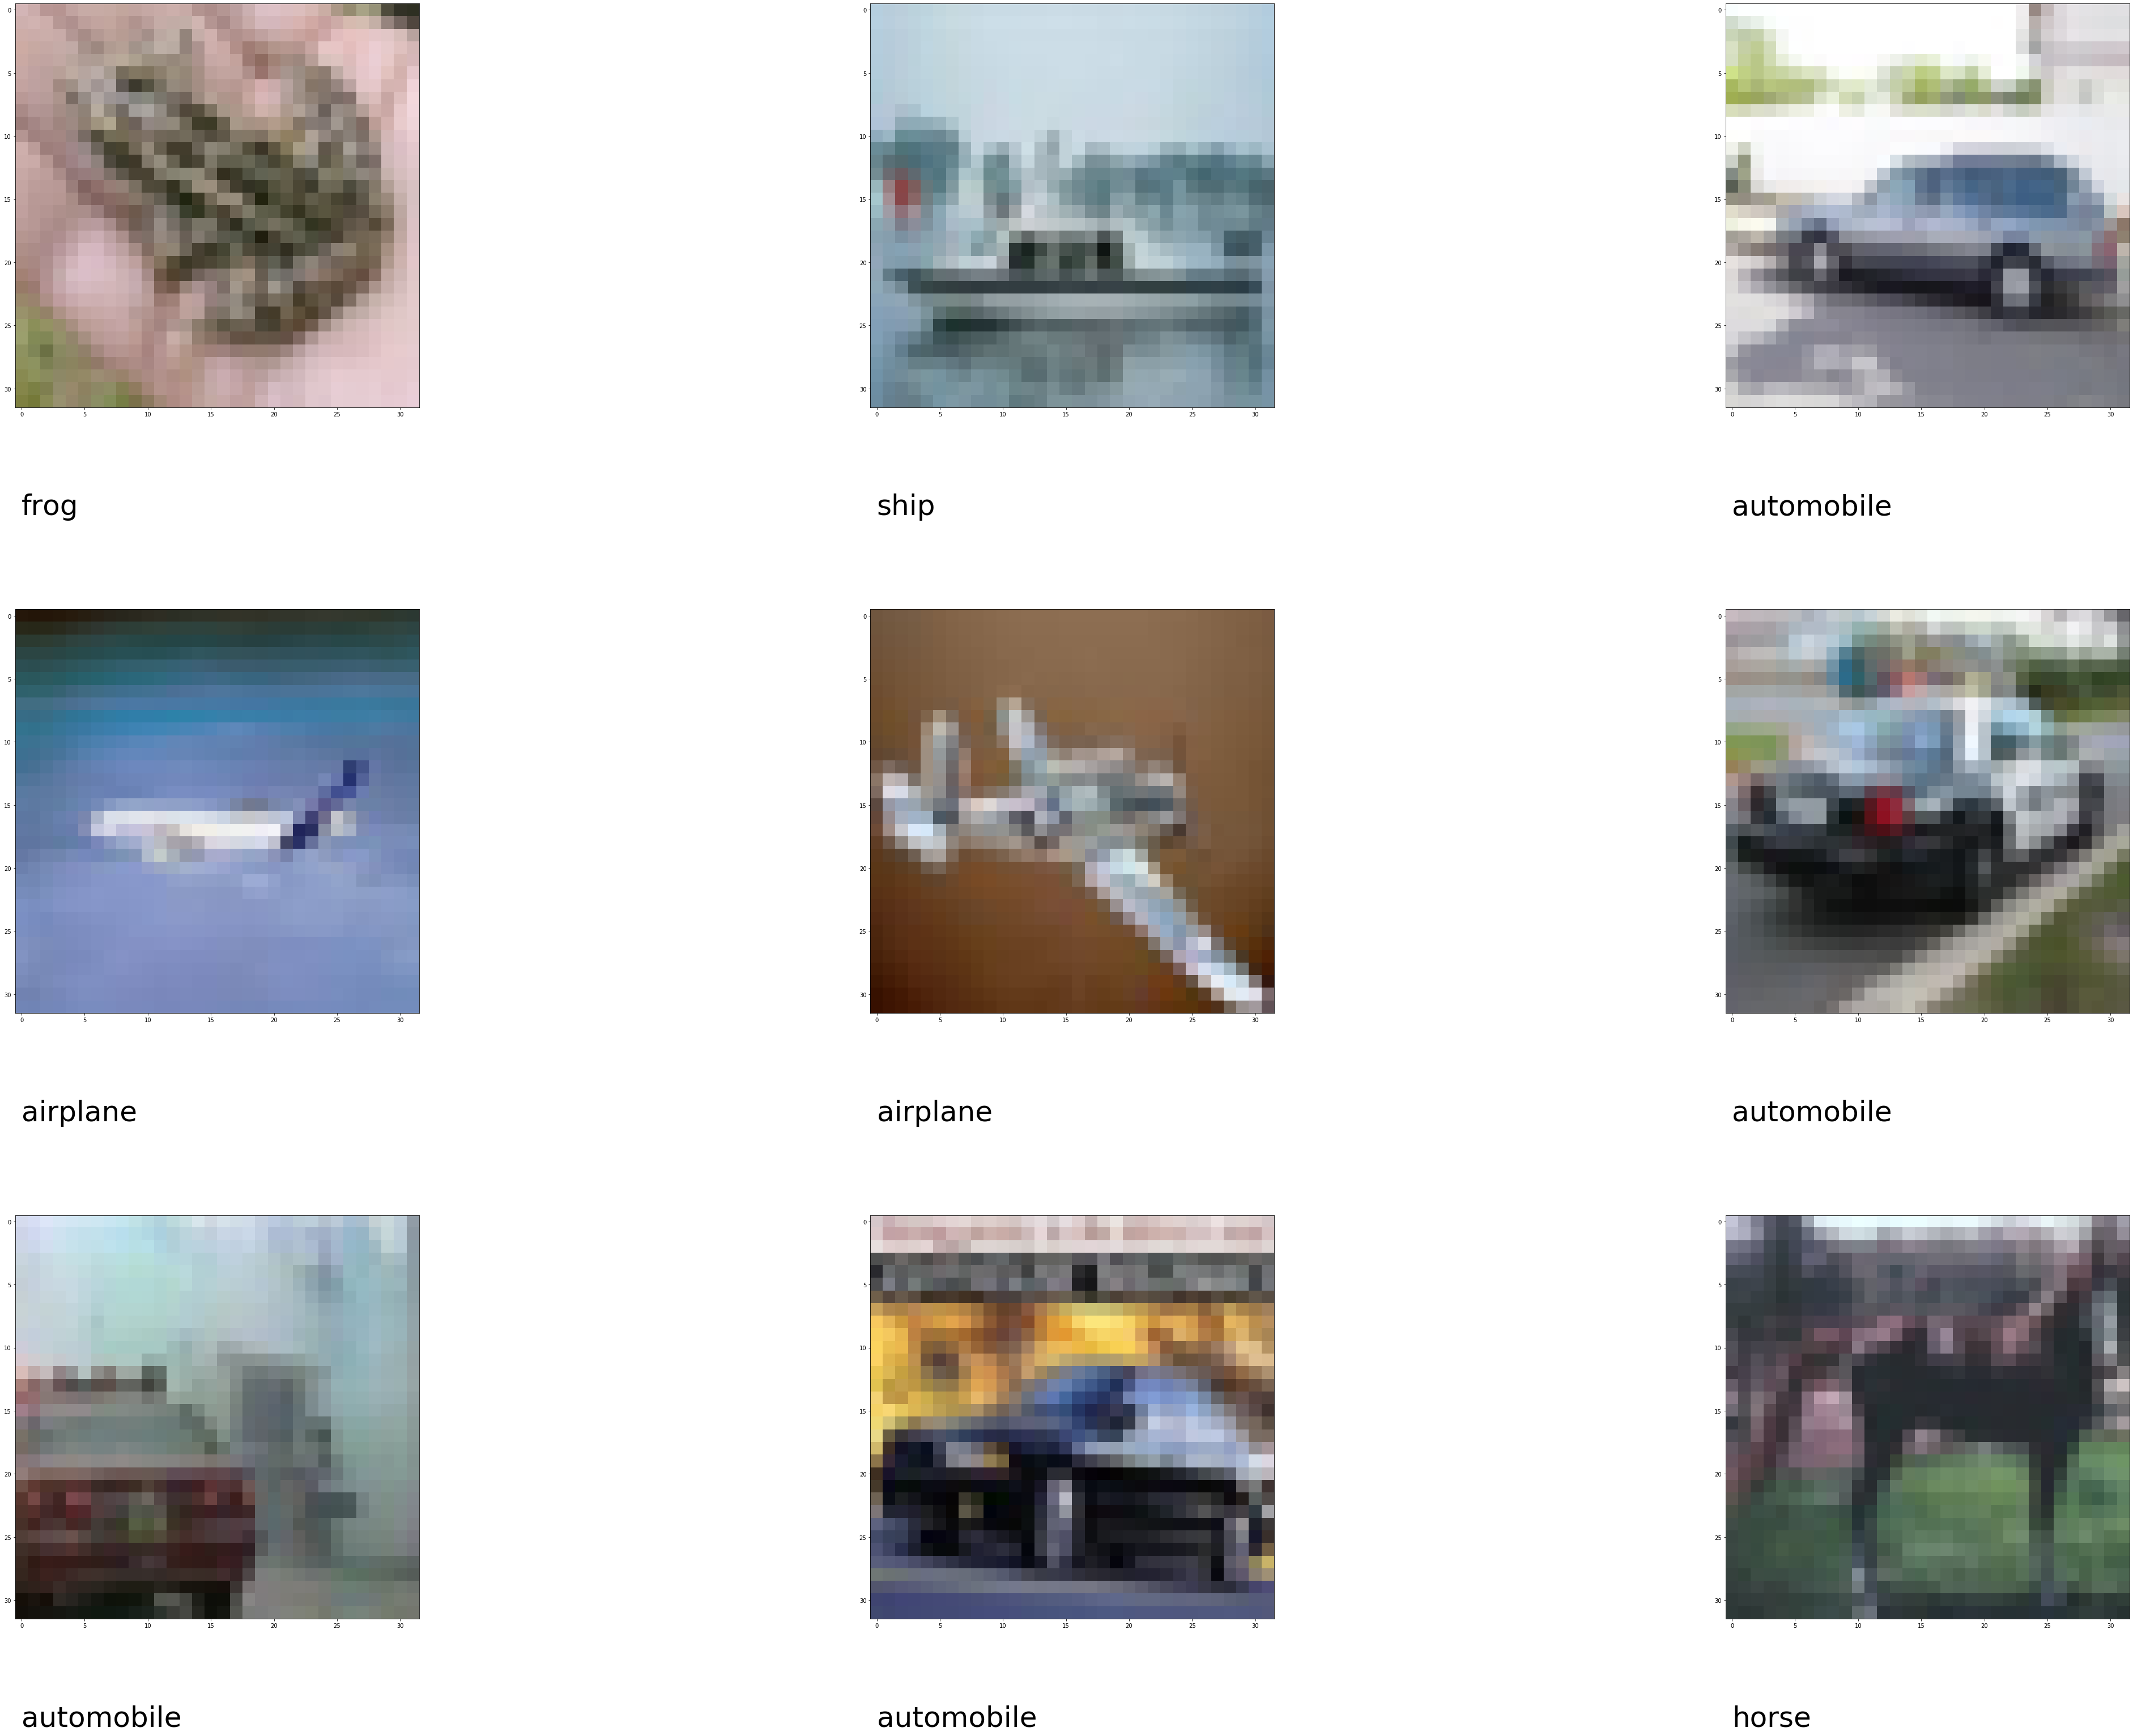

In [6]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [7]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [8]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [9]:
def create_model(conv1, conv2, conv3, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')
    
def create_or_load_model(name, model_params, train_func):
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.json'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        model = load_model(model_path)
        with open(history_path) as file:
            history = json.load(file)
    else:
        model = create_model(*model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'w') as file:
            json.dump(history.history, file)
            history = history.history
    return (model, history)

## Tests

Wir teste ein sehr kleines Netz, welches nicht in der Lage ist, die Features ausreichend zu abstrahieren, aber nach vielen Episoden irgendwann trotzdem genug Kapazität hat, um die Daten zu erinnern. 

In [24]:
FORCE_BUILD_MODELS=True
model_small, history_small = create_or_load_model('small', (3, 0, 0, 96), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 211us/step - loss: 2.1682 - acc: 0.2065 - val_loss: 1.9788 - val_acc: 0.2981
Epoch 2/100
50000/50000 [==============================] - 11s 226us/step - loss: 1.9040 - acc: 0.3200 - val_loss: 1.8370 - val_acc: 0.3444
Epoch 3/100
42112/50000 [========================>.....] - ETA: 2s - loss: 1.7927 - acc: 0.3591

KeyboardInterrupt: 

Parameter: 33,576
Final Accuracy: 0.62538; Final Validation Accuracy: 0.4959


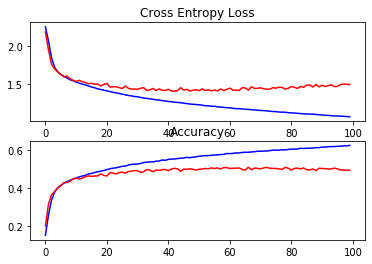

In [22]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

Es zeigt sich, dass ein kleines Netz mit 33 576 Parametern nicht in der Lage ist, die Daten ausreichend zu generalisieren, aber trotzdem nach genug Trainingsepisoden die 50 000 Trainingsdaten erinnern kann. 

Als nächstes ein Netz einer "normalen" Größe, welches in der Lage ist, die CIFAR10 Challange in einem ausreichenden Maß zu meistern.

In [12]:
model_normal, history_normal = create_or_load_model('normal', (64, 32, 0, 128), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Parameter: 329,994


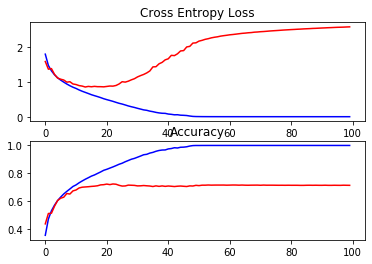

In [13]:
print("Parameter: {:,}".format(model_normal.count_params()))
plot_summary(history_normal)

Dieses Netz ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels als Y-Daten genutzt werden.

In [14]:
model_random, history_random = create_or_load_model('random', (64, 32, 0, 128), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64,  validation_data=(testX, testY)))


Parameter: 329,994


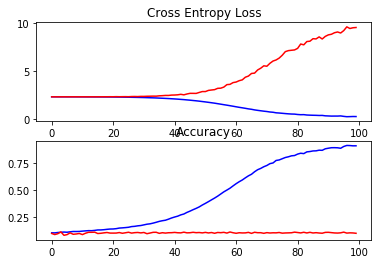

In [15]:
print("Parameter: {:,}".format(model_random.count_params()))
plot_summary(history_random)